Descargar los datos - después de extraer las características mediante un bloque de procesamiento- para poder entrenar un modelo de aprendizaje automático.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_d3a9d3ed55f124c19ae356f858bf2957fc232ef389cf0e4252874aa5bafc4c72'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/109095/training/5/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/109095/training/5/y')


Almacenar los datos en un archivo temporal, y cargarlos de nuevo a través de Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

Definir nuestras etiquetas y dividir los datos en un conjunto de prueba y otro de entrenamiento:

In [3]:
import sys, os, random
import tensorflow as tf
from sklearn.model_selection import train_test_split

import logging
tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "Bano", "cocina", "cuarto", "puerta", "sala" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


Entrenar el modelo:

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils 
import matplotlib.pyplot as plt

# model architecture
model = Sequential()
model.add(Reshape((int(input_length / 13), 13), input_shape=(input_length, )))
model.add(Conv1D(8, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Conv1D(16, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
EPOCHS = 100
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose=2, callbacks=callbacks)

# Use this flag to disable per-channel quantization for a model.
# This can reduce RAM usage for convolutional models, but may have
# an impact on accuracy.
disable_per_channel_quantization = False


Epoch 1/100
3/3 - 2s - loss: 2.1026 - accuracy: 0.2632 - val_loss: 1.5077 - val_accuracy: 0.4500 - 2s/epoch - 796ms/step
Epoch 2/100
3/3 - 0s - loss: 1.5296 - accuracy: 0.3947 - val_loss: 1.6220 - val_accuracy: 0.2500 - 75ms/epoch - 25ms/step
Epoch 3/100
3/3 - 0s - loss: 1.5474 - accuracy: 0.3026 - val_loss: 1.5771 - val_accuracy: 0.3500 - 110ms/epoch - 37ms/step
Epoch 4/100
3/3 - 0s - loss: 1.4607 - accuracy: 0.3553 - val_loss: 1.4011 - val_accuracy: 0.4500 - 87ms/epoch - 29ms/step
Epoch 5/100
3/3 - 0s - loss: 1.1703 - accuracy: 0.5789 - val_loss: 1.2814 - val_accuracy: 0.4500 - 45ms/epoch - 15ms/step
Epoch 6/100
3/3 - 0s - loss: 1.1508 - accuracy: 0.6053 - val_loss: 1.2024 - val_accuracy: 0.5500 - 88ms/epoch - 29ms/step
Epoch 7/100
3/3 - 0s - loss: 1.0071 - accuracy: 0.6579 - val_loss: 1.1560 - val_accuracy: 0.5500 - 54ms/epoch - 18ms/step
Epoch 8/100
3/3 - 0s - loss: 0.9252 - accuracy: 0.6842 - val_loss: 1.1271 - val_accuracy: 0.5500 - 61ms/epoch - 20ms/step
Epoch 9/100
3/3 - 0s - l

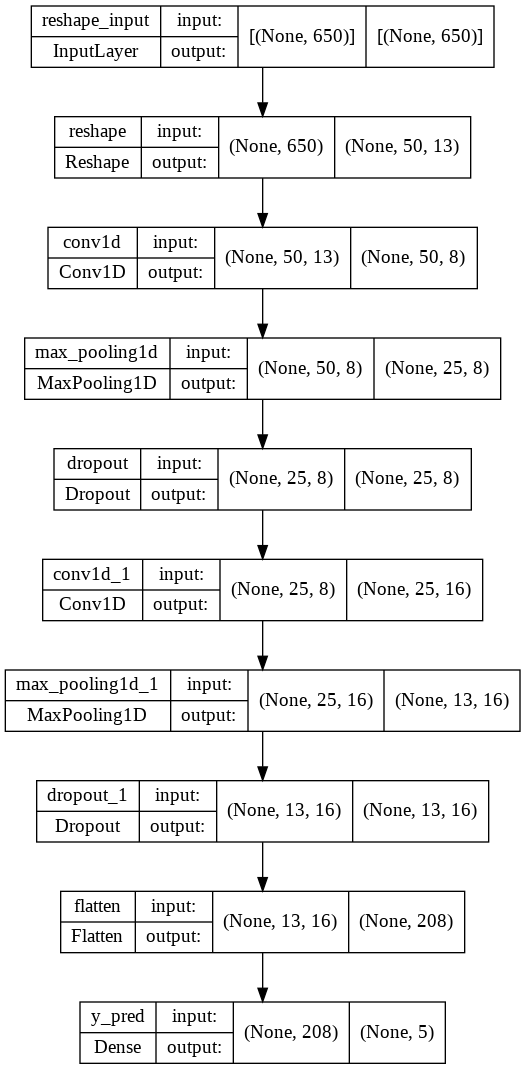

In [5]:
tf.keras.utils.plot_model(model, to_file='model_plot.png',
                          show_shapes=True, show_layer_names=True)

In [6]:
print(X_train.shape)
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    epochs=20, batch_size=32, verbose=0, shuffle=True)

(76, 650)


Graficar evolución del modelo

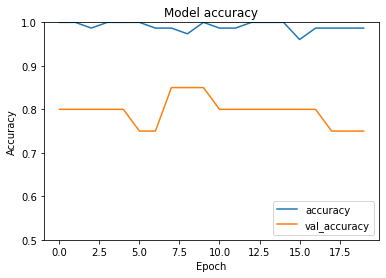

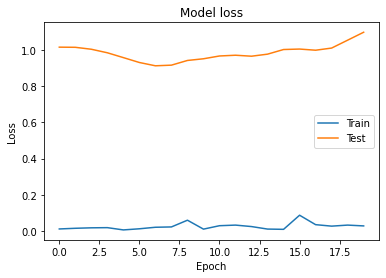

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [8]:
# Evaluación del modelo
Score = model.evaluate(X_test, Y_test, verbose=0)[1]

print(np.round(Score,decimals=4))

outputTrain=model.predict(X_test)

0.75


Matriz de confusion del modelo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.40      0.50         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         2
           4       0.25      0.33      0.29         3

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.74        20
weighted avg       0.76      0.75      0.75        20

[[5 0 0 0 0]
 [0 2 0 0 3]
 [0 0 5 0 0]
 [0 0 0 2 0]
 [0 1 1 0 1]]


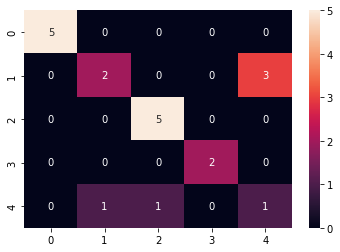

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
#import matplotlib.pyplot as plt
import pandas as pd

Y_test_class = np.argmax(Y_test,axis=1) 
Y_pred_class = np.argmax(outputTrain,axis=1) 

# Cálculo de las métricas 
print(classification_report(Y_test_class, Y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(Y_test_class, Y_pred_class)
print(cm)
# Visualización de la matriz de confusion en un mapa de calor
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [10]:
# The model is saved in Keras format
model.save('proyecto_final.h5')

In [11]:
# The model is saved in Tensorflow format
model.save('proyecto_final')

In [12]:
# Model is converted to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [13]:
model_tflite = converter.convert()

In [14]:
# The model is saved
open("/content/proyecto3.tflite","wb").write(model_tflite)

12596

In [15]:
# Convert a model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

In [16]:
# Save the model
open("/content/proyectofinal_quant.tflite","wb").write(tflite_quant_model)

9872

In [17]:
# Probar el modelo cuantizado
interpreter = tf.lite.Interpreter("/content/proyectofinal_quant.tflite")

In [18]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [19]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_reshape_input:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 650], dtype=int32),
  'shape_signature': array([ -1, 650], dtype=int32),
  'sparsity_parameters': {}}]

In [20]:
output_details

[{'dtype': numpy.float32,
  'index': 34,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 5], dtype=int32),
  'shape_signature': array([-1,  5], dtype=int32),
  'sparsity_parameters': {}}]

In [21]:
!apt-get update && apt-get -qq install xxd

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [788 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [22]:
MODEL_TFLITE = 'proyectofinal_quant.tflite'
MODEL_TFLITE_MICRO = 'modeloarduino.cc'
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}